# Read SEG-Y with `segyio`

This is a useful SEG-Y library from Equinor. In many cases, especially with 3D seismic, it is easy to use. But it's really intended as a developer library (not an app for interpreters etc), so you can really do more or less anything with it... with a bit of coding.

[`segyio` on GitHub](https://github.com/equinor/segyio)

[Read the Docs](https://segyio.readthedocs.io/en/latest/)

In [41]:
import segyio

In [2]:
help(segyio)

Help on package segyio:

NAME
    segyio - segyio

DESCRIPTION
    Welcome to segyio. For help, examples and reference, type ``help(function)`` in
    your favourite python interpreter, or ``pydoc function`` in the unix console.
    
    The segyio library attempts to be easy to use efficently for prototyping and
    interaction with possibly large segy files. File reading and writing is
    streaming, with large file support out of the box and without hassle. For a
    quick start on reading files, type ``help(segyio.open)``.
    
    An open segy file is interacted with in modes. For a reference with examples,
    please type ``help(segyio.segy)``, look at the online documentation at
    segyio.readthedocs.io, or run ``help()`` on the object returned by
    ``segyio.open``.. For documentation on individual modes, please
    refer to the individual modes with ``help(f.[mode])``, where ``f`` is an open
    file handle.
    
    The available modes are:
        * text, for textual heade

## Basics

We're using NumPy's data source manager here.

In [11]:
import numpy as np
import segyio

ds = np.DataSource('../data')  # <- Local target.
url = 'https://geocomp.s3.amazonaws.com/data/Penobscot_0-1000ms.sgy'
fname = ds.open(url).name  # <-- Could use any local file name.

with segyio.open(fname) as s:
    print("Binary header")
    print(s.bin)
    print()
    print("Text header")
    print(s.text[0])

Binary header
{JobID: 1, LineNumber: 0, ReelNumber: 0, Traces: 0, AuxTraces: 0, Interval: 4000, IntervalOriginal: 0, Samples: 251, SamplesOriginal: 0, Format: 5, EnsembleFold: 0, SortingCode: 4, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 1, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 1, SEGYRevisionMinor: 0, TraceFlag: 1, ExtendedHeaders: 0}

Text header
bytearray(b'\xa2\x90\x91\x80\x80\xa2\xbc\xb5/\xbe\xb5\xb4\x80\xb2`\x9a\x80!\xba\xb5>\xb4\xac\xb5\xb3\xbe\x80\x80\x80\x80\x80\x88\xab\xbf>\x80\x16\x91\x80\xa5\xb5\xb2\x80\x16\x90\x91\x96\x8c\x80\x91\x16\x9a\x91\x91\x9a\x94\x95\x89\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\x80\xa2\x90\x16\x80\x80\xab\xbf\xbc\xc0\x

This garbled text header is a bug. `segyio` currently (Jan 2019) assumes the header is EBCDIC encoded, but in this file it's ASCII encoded. It has been filed [as an issue](https://github.com/equinor/segyio/issues/317).

## Access the data

In [4]:
with segyio.open(fname) as s:
    c = segyio.cube(s)

`c` is just an `ndarray`.

In [5]:
type(c)

numpy.ndarray

In [16]:
c.shape

(601, 481, 251)

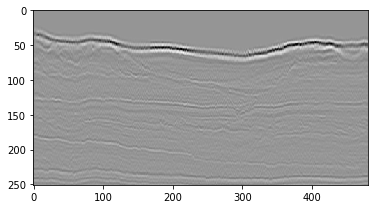

In [17]:
import matplotlib.pyplot as plt

plt.imshow(c[100].T, cmap='Greys')

Please refer to the **Intro to Matplotlib** notebook for more about visualizing seismic data with `matplotlib`.

## 2D data

Here's a 2D dataset:

https://github.com/agile-geoscience/geocomputing/blob/master/data/HUN00-ALT-01_STK.sgy

This file does not open with the default `strict=True`, but you can't use `segyio.cube()` with `strict=False`.

In [12]:
url = 'https://geocomp.s3.amazonaws.com/data/HUN00-ALT-01_STK.sgy'

# This should produce an error.
with segyio.open(ds.open(url).name, strict=False) as s:
    c = segyio.cube(s)

TypeError: object of type 'NoneType' has no len()

We could compile the traces manually, casting the traces explicitly to type, but then we need to know the format of the data, which means we need to read the binary header:

In [13]:
with segyio.open(ds.open(url).name, strict=False) as s:
    print(s.bin)

{JobID: 0, LineNumber: 0, ReelNumber: 0, Traces: 1, AuxTraces: 0, Interval: 1000, IntervalOriginal: 1000, Samples: 2000, SamplesOriginal: 2000, Format: 1, EnsembleFold: 1, SortingCode: 4, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 10, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 1, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}


The format is `1`, which is IBM single-precision (32-bit) floats. Now we can compile the traces like so:

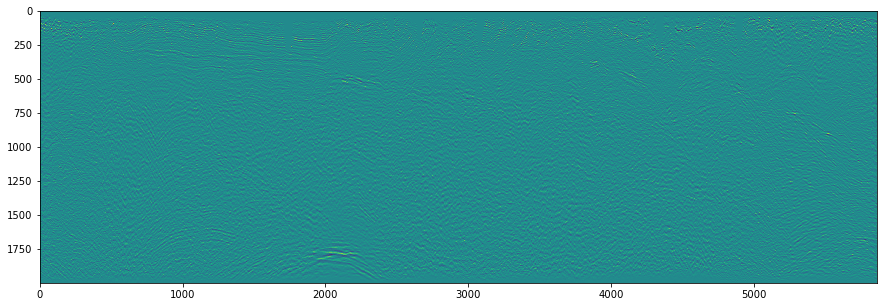

In [15]:
import matplotlib.pyplot as plt
import numpy as np

with segyio.open(ds.open(url).name, strict=False) as s:
    data = np.stack([t.astype(np.float32) for t in s.trace])
    
plt.figure(figsize=(15,5))
plt.imshow(data.T, aspect='auto', interpolation='none')

But this would be pretty tiresome for a 3D, so you'll be pleased to know that there's a better way:

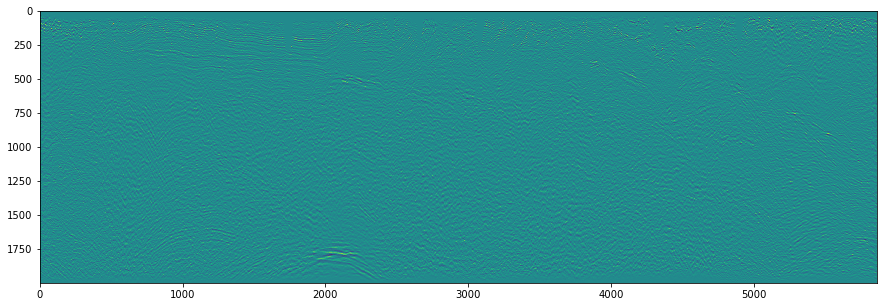

In [16]:
with segyio.open(ds.open(url).name, strict=False) as s:
    data = segyio.tools.collect(s.trace)
    
plt.figure(figsize=(15,5))
plt.imshow(data.T, aspect='auto', interpolation='none')

With a bit more work we can also read the file header and the trace headers.

In [17]:
import numpy as np

def chunks(s, n):
    """Produce `n`-character chunks from string `s`."""
    for start in range(0, len(s), n):
        yield s[start:start + n]

with segyio.open(ds.open(url).name, strict=False) as s:
    
    # Read the data.
    data = segyio.tools.collect(s.trace)
    
    # Get the (x, y) locations.
    x = [t[segyio.TraceField.GroupX] for t in s.header]
    y = [t[segyio.TraceField.GroupY] for t in s.header]
    
    # Get the trace numbers.
    cdp = np.array([t[segyio.TraceField.CDP] for t in s.header])

    # Get the first textual header.
    header = s.text[0].decode('ascii')
    formatted = '\n'.join(chunk for chunk in chunks(header, 80))

    # Get data from the binary header.
    # Get the sample interval in ms (convert from microsec).
    sample_interval = s.bin[segyio.BinField.Interval] / 1000

print(formatted)

C01  PROCESSED BY: VERITAS GEOSERVICES LTD.                                     
C02  CLIENT      : HUNT OIL COMPANY                                             
C03  AREA        : ALTON                                                        
C04  LINE        : ALT-01                                                       
C05  DATA   NOISE ATTENUATED STRUCTURE STACK                                    
C06         (FILTERED/SCALED)                                                   
C07                                                                             
C08                                                                             
C09  SAMPLE RATE   2 MS.                                                        
C10  FIELD DATA LENGTH 3.0 SEC.; (PROCESSED TO 2.0 SEC)                         
C11  PROCESSING SEQUENCE:                                                       
C12  DEMULTIPLEX:SAMPLE RATE:1 MS RECORD LEN.:3 SEC.S                           
C13  GEOMETRY               

Getting a sub-set of traces using CDP (or trace number or similar) is a little fiddly:

In [18]:
cdp

array([   1,    2,    3, ..., 5857, 5858, 5859])

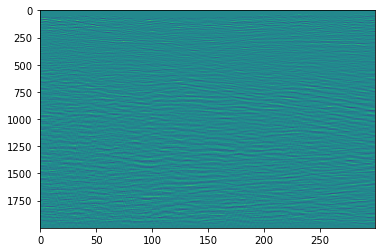

In [19]:
selection = np.where((cdp>500) & (cdp<800))[0]
subset = data[selection]

plt.imshow(subset.T, aspect='auto')

---

© Agile Scientific 2021